In [1]:
import pandas as pd
pd.set_option('display.max_rows', 100)
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import re
from tqdm import tqdm
import pickle

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

### Load Predictions of Base Models

In [2]:
DATA_FOLDER = "../data/"

models = ["RF", "LR", "NB","LR_BERT","SVM"] #["LR", "NB", "SVM"]  
meta_model_train = pd.DataFrame()
meta_model_test = pd.DataFrame()
meta_model_fold_1 = pd.DataFrame()
meta_model_fold_2 = pd.DataFrame()
meta_model_fold_3 = pd.DataFrame()
meta_model_fold_4 = pd.DataFrame()
meta_model_fold_5 = pd.DataFrame()

for model in models:
    fold1pred = pd.read_csv(DATA_FOLDER +f'fold_predictions/{model}/{model}_fold1.csv')
    meta_model_fold_1 = pd.concat([meta_model_fold_1,fold1pred], axis=1)
    
    fold2pred = pd.read_csv(DATA_FOLDER +f'fold_predictions/{model}/{model}_fold2.csv')
    meta_model_fold_2 = pd.concat([meta_model_fold_2,fold2pred], axis=1)

    fold3pred = pd.read_csv(DATA_FOLDER +f'fold_predictions/{model}/{model}_fold3.csv')
    meta_model_fold_3 = pd.concat([meta_model_fold_3,fold3pred], axis=1)

    fold4pred = pd.read_csv(DATA_FOLDER +f'fold_predictions/{model}/{model}_fold4.csv')
    meta_model_fold_4 = pd.concat([meta_model_fold_4,fold4pred], axis=1)

    fold5pred = pd.read_csv(DATA_FOLDER +f'fold_predictions/{model}/{model}_fold5.csv')    
    meta_model_fold_5 = pd.concat([meta_model_fold_5,fold5pred], axis=1)

    all_pred_train = pd.concat([fold1pred,fold2pred,fold3pred,fold4pred,fold5pred],axis = 0)
    meta_model_train = pd.concat([meta_model_train,all_pred_train], axis=1)
    
    testpred = pd.read_csv(DATA_FOLDER +f'fold_predictions/{model}/{model}_test.csv')
    meta_model_test = pd.concat([meta_model_test,testpred], axis=1)

    
data = [meta_model_fold_1,meta_model_fold_2,meta_model_fold_3,meta_model_fold_4,meta_model_fold_5,meta_model_train]
meta_model_train.head()

,RF_prob_0,RF_prob_1,LR_prob_0,LR_prob_1,NB_prob_0,NB_prob_1,LR_BERT_prob_0,LR_BERT_prob_1,SVM_prob_0,SVM_prob_1,relevance
0,0.888844,0.111156,0.904929,0.095071,1.000000,1.285402e-13,0.990048,0.009952,0.999931,0.000069,0
1,0.768334,0.231666,0.812720,0.187280,0.824749,1.752507e-01,0.348586,0.651414,0.999931,0.000069,0
2,0.977650,0.022350,0.881204,0.118796,0.982464,1.753636e-02,0.935040,0.064960,0.999931,0.000069,0
3,0.937968,0.062032,0.954398,0.045602,1.000000,1.739279e-09,0.999708,0.000292,0.999993,0.000007,0
4,0.694125,0.305875,0.837683,0.162317,1.000000,4.291682e-08,0.944173,0.055827,0.999931,0.000069,0


# Stacking

In [46]:
# logistic regression
logreg_params = {
    "C": [0.1, 0.5, 1.0, 1.5, 5],
    "solver": ["lbfgs", "newton-cg"],
    "penalty": ["l2", "none"],
    "class_weight": ["balanced", None] 
}
logreg_paramgrid = list(ParameterGrid(logreg_params))

# svm
svm_params = {
    "C": [0.1, 0.5, 1.0, 1.5, 5],
    "kernel": ["poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
    "class_weight": ["balanced", None] 
}

svm_paramgrid = list(ParameterGrid(svm_params))

In [47]:
def oversample_smote(X,y):
    smote = SMOTE(random_state = 4103)
    X, y = smote.fit_resample(X, y)
    return X,y

In [48]:
def models_grid_search(model_name, model_fn, model_paramgrid, data, test) : 
    ind = 0 
    gridsearch_results = []      
    
    # train models
    for model_param in model_paramgrid:

        # 5 fold cross val
        val_accuracy = []
        val_f1_weighted = []
        val_f1_zero = []
        val_f1_one = []
    
        test_accuracy = []
        test_f1_weighted = []
        test_f1_zero = []
        test_f1_one = []
        
        for i in range(5):
            print(f"fold {i}")
            train_set = pd.DataFrame()
            for x in range(5):
                if i != x :
                    train_set = pd.concat([train_set,data[x]],axis=0)
            val_set = data[i]
            test_set = test
            trainval_set = data[5]

            train_label = train_set.relevance
            val_label = val_set.relevance
            test_label = test_set.relevance
            trainval_label = trainval_set.relevance

            # train on train model test on val
            model = model_fn(**model_param)
            vec_train_over, label_train_over = oversample_smote(train_set.iloc[:,:-1],train_label)
            model.fit(vec_train_over, label_train_over)
            val_pred = model.predict(val_set.iloc[:,:-1])
            
            # scoring
            val_metrics = classification_report(val_label, val_pred, output_dict=True)
            val_accuracy.append(val_metrics["accuracy"])
            val_f1_weighted.append(val_metrics["weighted avg"]["f1-score"])
            val_f1_zero.append(val_metrics["0"]["f1-score"])
            val_f1_one.append(val_metrics["1"]["f1-score"])

            # train on train_val model test on test
            model = model_fn(**model_param)
            vec_tv_over, label_tv_over = oversample_smote(trainval_set.iloc[:,:-1],trainval_label)
            model.fit(vec_tv_over, label_tv_over)
            test_pred = model.predict(test_set.iloc[:,:-1])
            # scoring
            test_metrics = classification_report(test_label, test_pred, output_dict=True)
            test_accuracy.append(test_metrics["accuracy"])
            test_f1_weighted.append(test_metrics["weighted avg"]["f1-score"])
            test_f1_zero.append(test_metrics["0"]["f1-score"])
            test_f1_one.append(test_metrics["1"]["f1-score"])

        results = { "model": model_name }
        results.update(model_param)
        results.update({"val_f1_weighted": np.mean(val_f1_weighted), 
                        "val_f1_zero": np.mean(val_f1_zero), "val_f1_one": np.mean(val_f1_one),
                        "val_accuracy": np.mean(val_accuracy)})
        results.update({"test_f1_weighted": np.mean(test_f1_weighted),
                        "test_f1_zero": np.mean(test_f1_zero), "test_f1_one": np.mean(test_f1_one),
                        "test_accuracy": np.mean(test_accuracy)})
        gridsearch_results.append(results)
        ind += 1
    return gridsearch_results

In [ ]:
model_name = "logreg"
model_fn = LogisticRegression
model_paramgrid = logreg_paramgrid
final_logreg_results = pd.DataFrame.from_records(models_grid_search(model_name,model_fn,model_paramgrid, data, meta_model_test))

In [21]:
final_logreg_results = final_logreg_results.sort_values(by=["val_f1_one", "test_f1_one"], ascending=False)
final_logreg_results

,model,C,class_weight,penalty,solver,val_f1_weighted,val_f1_zero,val_f1_one,val_accuracy,test_f1_weighted,test_f1_zero,test_f1_one,test_accuracy
0,logreg,0.1,balanced,l2,lbfgs,0.885653,0.921473,0.492290,0.864200,0.873867,0.912281,0.528875,0.852099
1,logreg,0.1,balanced,l2,newton-cg,0.885653,0.921473,0.492290,0.864200,0.873867,0.912281,0.528875,0.852099
4,logreg,0.1,None,l2,lbfgs,0.885653,0.921473,0.492290,0.864200,0.873867,0.912281,0.528875,0.852099
5,logreg,0.1,None,l2,newton-cg,0.885653,0.921473,0.492290,0.864200,0.873867,0.912281,0.528875,0.852099
8,logreg,0.5,balanced,l2,lbfgs,0.881543,0.918083,0.480793,0.858711,0.867445,0.906712,0.514793,0.843511
9,logreg,0.5,balanced,l2,newton-cg,0.881543,0.918083,0.480793,0.858711,0.867445,0.906712,0.514793,0.843511
12,logreg,0.5,None,l2,lbfgs,0.881543,0.918083,0.480793,0.858711,0.867445,0.906712,0.514793,0.843511
13,logreg,0.5,None,l2,newton-cg,0.881543,0.918083,0.480793,0.858711,0.867445,0.906712,0.514793,0.843511
16,logreg,1.0,balanced,l2,lbfgs,0.881636,0.918253,0.480046,0.858950,0.867445,0.906712,0.514793,0.843511
17,logreg,1.0,balanced,l2,newton-cg,0.881636,0.918253,0.480046,0.858950,0.867445,0.906712,0.514793,0.843511


In [ ]:
final_logreg_results = final_logreg_results.sort_values(by=["val_f1_weighted", "test_f1_weighted"], ascending=False)
#final_logreg_results.to_csv('model_results/stacking_results_lr_no_rf.csv')

In [ ]:
model_name = "svm"
model_fn = SVC
model_paramgrid = svm_paramgrid
final_svm_results = pd.DataFrame.from_records(models_grid_search(model_name,model_fn,model_paramgrid, data, meta_model_test))

In [24]:
final_svm_results = final_svm_results.sort_values(by=["val_f1_one", "test_f1_one"], ascending=False)
#final_svm_results.to_csv('model_results/stacking_results_svm_norf.csv')
final_svm_results

,model,C,class_weight,gamma,kernel,val_f1_weighted,val_f1_zero,val_f1_one,val_accuracy,test_f1_weighted,test_f1_zero,test_f1_one,test_accuracy
2,svm,0.1,balanced,scale,sigmoid,0.919555,0.954985,0.529215,0.917900,0.909523,0.948936,0.555556,0.908397
8,svm,0.1,None,scale,sigmoid,0.919555,0.954985,0.529215,0.917900,0.909523,0.948936,0.555556,0.908397
53,svm,5.0,balanced,auto,sigmoid,0.900354,0.935098,0.517780,0.885680,0.892253,0.929873,0.554386,0.878817
59,svm,5.0,None,auto,sigmoid,0.900354,0.935098,0.517780,0.885680,0.892253,0.929873,0.554386,0.878817
5,svm,0.1,balanced,auto,sigmoid,0.894366,0.930058,0.502008,0.877566,0.882565,0.920493,0.541935,0.864504
11,svm,0.1,None,auto,sigmoid,0.894366,0.930058,0.502008,0.877566,0.882565,0.920493,0.541935,0.864504
41,svm,1.5,balanced,auto,sigmoid,0.892416,0.928836,0.492556,0.875418,0.892007,0.929950,0.551237,0.878817
47,svm,1.5,None,auto,sigmoid,0.892416,0.928836,0.492556,0.875418,0.892007,0.929950,0.551237,0.878817
17,svm,0.5,balanced,auto,sigmoid,0.888764,0.924947,0.491916,0.869451,0.880911,0.919373,0.535484,0.862595
23,svm,0.5,None,auto,sigmoid,0.888764,0.924947,0.491916,0.869451,0.880911,0.919373,0.535484,0.862595


### Get best model & train on all data & save model

In [58]:
alldata = pd.concat([meta_model_train,meta_model_test],axis=0)

In [52]:
best_param = {"C": final_svm_results.iloc[0,:].to_dict()["C"],
             "class_weight" : final_svm_results.iloc[0,:].to_dict()["class_weight"] , 
              "gamma" : final_svm_results.iloc[0,:].to_dict()["gamma"], 
              "kernel" : final_svm_results.iloc[0,:].to_dict()["kernel"]}
final_model = SVC(**best_param,probability=True)

#oversample
vec_train_over, label_train_over = oversample_smote(alldata.iloc[:,:-1], alldata.relevance)

final_model.fit(vec_train_over, label_train_over)

model_pkl_filename = DATA_FOLDER + "saved_models/relevance_models/model_meta.pkl"
with open(model_pkl_filename, 'wb') as file:
    pickle.dump(final_model, file)

In [53]:
meta_model = pickle.load(open(model_pkl_filename, "rb"))
meta_model.predict(vec_train_over)

array([0, 0, 0, ..., 1, 0, 1])

In [56]:
meta_model.predict_proba(vec_train_over)

array([[5.75516773e-01, 4.24483227e-01],
       [6.62391178e-01, 3.37608822e-01],
       [5.86514006e-01, 4.13485994e-01],
       ...,
       [9.38644945e-14, 1.00000000e+00],
       [6.48931738e-01, 3.51068262e-01],
       [4.58985189e-01, 5.41014811e-01]])

### Prediction Correlation

In [4]:
alldata = pd.concat([meta_model_train, meta_model_test])

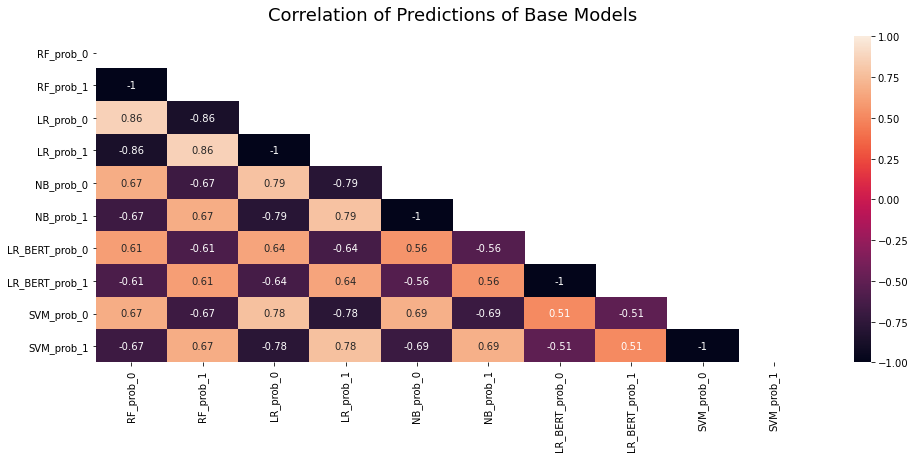

In [5]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(alldata.iloc[:,:-1].corr(), dtype=np.bool))
heatmap = sns.heatmap(alldata.iloc[:,:-1].corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation of Predictions of Base Models', fontdict={'fontsize':18}, pad=16);